# Imports

In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from psi_analyzer import PSIAnalyzer


In [6]:
list_ = list(np.random.normal(0.4, 0.1, 100))
data = pd.DataFrame({
            'model': ['a'] * 500,
            'env': ['DEV'] * 100 + ['PRD'] * 400,
            'score': list_ + list_ + list(
                np.random.normal(0.45, 0.1, 100)
                ) + list(
                np.random.normal(0.6, 0.2, 100)
                ) + list(
                np.random.normal(0.4, 0.1, 100)
                ),
            'year_month': ['2023-01'] * 100 + ['2023-02'] * 100 + ['2023-03'] * 100 + ['2023-04'] * 100 + ['2023-05'] * 100
    })
spark = SparkSession.builder.master("local[1]").appName("PSIUnitTest").getOrCreate()
spdf = spark.createDataFrame(data)
spdf = spdf.withColumn("year", F.year(F.to_date(spdf.year_month, "yyyy-MM")))
spdf = spdf.withColumn("month", F.month(F.to_date(spdf.year_month, "yyyy-MM")))

# Calcular o psi


Agora vamos calcular o PSI (`Population Stability Index`) — uma métrica usada para comparar a distribuição de uma variável (geralmente score) entre dois conjuntos (ex: dev vs oot).

---

✅ Passo a passo para calcular o PSI

O PSI é calculado assim, para cada faixa de score:

$$\text{PSI} = \sum \left( (p_i - q_i) \cdot \ln\left(\frac{p_i}{q_i}\right) \right)$$

Onde:

*	p_i: proporção da faixa i no ambiente de referência (ex: dev)
*	q_i: proporção da mesma faixa no ambiente de comparação (ex: oot)

---


In [7]:
analyzer = PSIAnalyzer(
            df=spdf,
            model_col='model',
            env_col='env',
            score_col='score',
            year_col='year',
            month_col='month',
            n_bins=10
        )

# --- Act ---
psi_df = analyzer.compute_psi()
psi_df.show(10)

+-----+---+----+-----+-------------------+----------+
|model|env|year|month|                psi|      data|
+-----+---+----+-----+-------------------+----------+
|    a|PRD|2023|    2|                0.0|2023-02-01|
|    a|PRD|2023|    3|0.31225438987562565|2023-03-01|
|    a|PRD|2023|    4| 1.6246342715662871|2023-04-01|
|    a|PRD|2023|    5| 0.2064468035021594|2023-05-01|
+-----+---+----+-----+-------------------+----------+



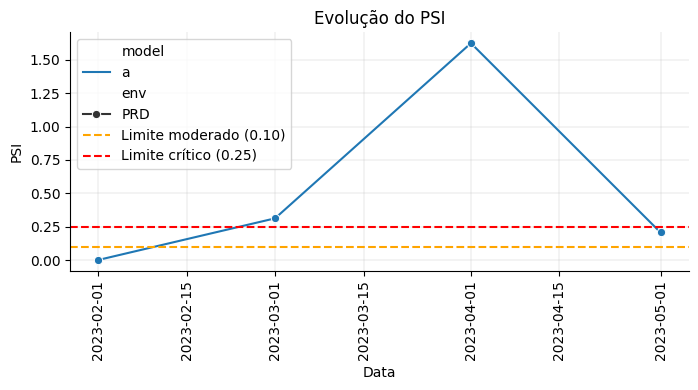

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(7, 4))

# Plot principal
sns.lineplot( 
    x='data', y='psi',
    hue='model', style='env',
    data=psi_df.toPandas(), dashes=False,
    markers=True, markeredgecolor='w', ax=ax
)

# Linhas horizontais com labels manuais
linha_moderada = ax.axhline(0.1, color="orange", linestyle="--", label="Limite moderado (0.10)")
linha_critica = ax.axhline(0.25, color="red", linestyle="--", label="Limite crítico (0.25)")

# Título e eixos
plt.title("Evolução do PSI")
plt.xlabel("Data")
plt.ylabel("PSI")
plt.xticks(rotation=90)

# Estética
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
ax.xaxis.grid(True, linestyle='-', linewidth=0.2)
plt.tight_layout()

# Combinar legendas de Seaborn + linhas horizontais
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # remove duplicatas se houver
ax.legend(by_label.values(), by_label.keys(), loc='best')

plt.show()